Event Driven Simulation 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Scheduling CoMP
---------

In [648]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 



def df_to_ue_lists(df,cluster,thr):

    cluster=[19,20]
    df_filter=df.groupby('PCI Serving')
    ue_dict={}
    for i in cluster:
        counter=0
        ue_list=np.array([])
        df2=df_filter.get_group(i)
        for j in df2.index:
            ue_list=np.append(ue_list, ue(df.iloc[j]['JT_1 SINR [lin]'],df.iloc[j]['JT_2 SINR [lin]'],df.iloc[j]['PCI Serving'],df.iloc[j]['PCI Coord'],env,df.iloc[j]['usage'], thr,df.iloc[j]['id']))
        ue_dict[i]= ue_list
    return ue_dict

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_prb_number(users,max_prb):
    count=0
    count2=0
    for i in np.arange(len(users)):
        if(users[i].comp ==1):
            if(users[i].qos==0):
                count+=1
            if(users[i].qos==1):
                count+=4
            if(users[i].qos==2):
                count+=75
                
        elif(users[i].comp ==0):
            if(users[i].qos==0):
                count2+=1
            if(users[i].qos==1):
                count2+=4
            if(users[i].qos==2):
                count2+=75
    prb_number=round(count/count2*max_prb)
    return prb_number

def get_dataframe(users):
    df=pd.DataFrame()
    sinr=np.array([])
    sinr2=np.array([])
    tbs=np.array([])
    queue=np.array([])
    
    for i in np.arange(np.size(users)):
        sinr=np.append(sinr,users[i].sinr)
        sinr2=np.append(sinr,users[i].sinr2)
        tbs=np.append(sinr,users[i].tbs)
        queue=np.append(sinr,users[i].queue)
    df['sinr']=sinr
    df['sinr2']=sinr2
    df['tbs']=tbs
    df['queue']=queue
    return df

def calculate_tbs(sinr,sinr2):
    sinr=int(sinr)
    sinr2=int(sinr2)
    if(sinr>30 or sinr2>30):
        print('sinr out of range')
        tbs=30
        tbs2=30
    elif(sinr<-10):
        print('sinr out of range')
        tbs=-10
        tbs2=-10
    else:
        mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
        tbs=mapping.iloc[sinr].values[1]
        tbs2=mapping.iloc[sinr2].values[1]
    return tbs,tbs2

def central_scheduler(env, users, SCHEDULE_T,cluster, prb_number):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    print('new scheduling round:')
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
    

        for i in np.arange(np.size(users)): 
            if(users[i].qos==1 or users[i].qos==2):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                elif(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        remaining_prb_list={}
        for i in cluster:
            remaining_prb_list[i]=prb_number
            
        k=0
        print('New scheduling round')
        free_res=1
        
        while(free_res==1):
            sched_user=sched_user_list[k]
            cell1=int(users[sched_user].cell1)
            cell2=int(users[sched_user].cell2)
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs
            tbs2=users[sched_user].tbs2
            remaining_prbs=remaining_prb_list[cell1]
            remaining_prbs_c2=remaining_prb_list[cell2]
            #print('Resourcen:',remaining_prb_list[cell1])
            #print('Resourcen:',remaining_prb_list[cell2])
            #serving cell has no resources left -> no scheduling 
            if(remaining_prbs_c2==0):
                #print('keine Res mehr frei')
                continue
            #cell to coordinate with has no resources left -> without comp
            elif(remaining_prbs_c2==0):
                #print('ohne CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs)
                
            elif((queue_size/tbs2)<=remaining_prbs and (queue_size/tbs2)<=remaining_prbs_c2 and queue_size>0):
            #comp can be used
                #print('mit CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(queue_size/tbs2)
            #one of the cells has not enough resources left 
            elif((queue_size/tbs2)>remaining_prbs or (queue_size/tbs2)>remaining_prbs_c2):
                #print('mit CoMP - v2')
                sched_size=min(remaining_prbs,remaining_prbs_c2)*tbs2
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(sched_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(sched_size/tbs2)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')

            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            #print('Queue nachher:',users[sched_user].queue.level)
            k=k+1
            free_res=0
            for i in cluster:
                if(remaining_prb_list[i]!=0):
                    free_res=1
                    
        counter=counter+2
        
        


#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T,cluster, prb_number, users2, prb_number2, sched_metric):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    bits1=0
    bits2=0
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
        #users[0].mon= monitor(users[0].queue,users[0].mon)
        #users[10].mon= monitor(users[10].queue,users[10].mon)
        #users[120].mon= monitor(users[120].queue,users[120].mon)
        #users[100].mon= monitor(users[100].queue,users[100].mon)
        
        
        for i in np.arange(np.size(users)): 
            if(users[i].qos==1 or users[i].qos==2):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                elif(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        remaining_prbs=prb_number
        
        k=0
        print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
          
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            users[sched_user].bits+=sched_size
            k=k+1
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users[sched_user].mR)
                print(counter)
        #TEST
        ############################
        metric=np.array([])
        for i in users2: 
            if(i.qos==1 or i.qos==2):
                metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process 
                i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer    
            elif(i.qos==0):
                if(i.queue2.level>0):
                    metric=np.append(metric,(i.cp/i.mR2))
                    i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer
                elif(i.queue2.level==0):
                    metric=np.append(metric,0)
                    i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer


        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        print(sched_user_list) 
        #print(sched_user_list)    
        #print(users[2].queue.level)
        remaining_prbs=prb_number2
        
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users2[sched_user].queue2.level
            tbs=users2[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            
            users2[sched_user].mR2=users2[sched_user].mR2+(1/counter)*sched_size
            users2[sched_user].queue2.get(sched_size)
            users2[sched_user].bits2+=sched_size
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users2[sched_user].mR2)
                print(counter)
            
            k=k+1
        ###########################

        counter=counter+2
        

class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos,thr,id):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs,self.tbs2=calculate_tbs(sinr,sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.mR2=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.queue2=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        self.metric2=self.sinr+self.queue.level
        self.gain=self.sinr2-self.sinr
        self.id=id
        self.bits=0
        self.bits2=0
        if(self.gain >thr):
            self.comp=np.array(1)
        else:
            self.comp=np.array(0) 
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                self.queue2.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            self.queue2.put(2000) 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(150) #1080p-> 1.5 Mbps (normal 1500)
            self.queue2.put(150) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)


In [649]:
env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=50
thr=6
cluster=[19,20]


x=np.append(np.ones(70)*19,np.ones(70)*20)
y=np.append(np.ones(70)*20,np.ones(70)*19)
sinr=np.random.randint(0,12,70*2)
sinr2=np.random.randint(2,16,70*2)
rt_nrt=np.array([])
rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))

rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))


df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
df['id']=np.arange(0,140)
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')


ue_dict=df_to_ue_lists(df,[19,20],6)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp


In [650]:
#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,50):
        env.process(ue_list[j].user_packets(env,50))
        #env.process(ue_list[i].sinr_variator()) #movement
    env.process(ue_list[50].streaming_user(env))
    env.process(ue_list[51].streaming_user(env))
    #env.process(ue_list[100].sinr_variator()) #movement   
    for j in np.arange(52,70):
        env.process(ue_list[j].rt_user(env))
        #env.process(ue_list[i].sinr_variator()) #movement

        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_19=ue_all[counter*70:((counter+1)*70-1)]
    env.process(scheduler(env,ue_list,SCHEDULE_T,[19,20],prb_number_normal,ue_19,50))
env.run(until=5000)

new scheduling round:
New scheduling round
New scheduling round
[50 51 30 49 25 14 56 47 33  0  6 39  8 42 19 23 44 46 15  2 27 16 35 20
 13 41  7 48 22 45 28 32 38 43 36 34  3  5 11 37 29 24 21 31  1  4  9 10
 12 17 18 40 26 66 65 64 63 62 61 60 52 58 57 55 54 53 67 59 68]
New scheduling round
[ 0 27 28 29 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47 48 56 26 24
 34  4  5  6  7  8  9 10 11 12 13 23 14  2 16 17 18  1 19 20 21 22 15  3
 25 49 50 51 30 66 65 64 63 62 61 60 58 67 57 55 54 53 52 59 68]
ue-number sched1: 0
2000.0
1
New scheduling round
New scheduling round
[34 26 28 29 56 31 32 33 51 35 36 37 38 39 40 41 42 43 44 45 46 47 25 48
 24 22  1  2  3  4  5  6  7  8  9 10 23 11 13 14 15 16 17 18 19 20 21 12
 50 27  0 30 49 67 66 65 64 63 62 61 59 58 57 55 54 53 52 60 68]
New scheduling round
[24 26 28 29 56 31 32 33 51 35 36 37 38 39 40 41 42 43 44 45 46 47 25 48
 50 22  1  2  3  4  5  6  7  8  9 10 23 11 13 14 15 16 17 18 19 20 21 12
 34 27  0 30 49 67 66 65 64 63 62 61 59 58 5

<ipython-input-648-5aea26fc0d1a>:252: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(i.cp/i.mR2))
<ipython-input-648-5aea26fc0d1a>:248: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process
<ipython-input-648-5aea26fc0d1a>:248: RuntimeWarning: invalid value encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(i.cp/i.mR2)))  #list the metric of all UEs in the process
<ipython-input-648-5aea26fc0d1a>:108: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))
<ipython-input-648-5aea26fc0d1a>:104: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process
<ipython-input-648-5aea26fc0d1a>:104: RuntimeWarning: invalid value en

[14 15  7 33  2 47 39  8 31 13 18 42 38 34  1 26 21 37 20 44 22 16 27 24
 43 40  9 41 12  5  3 29 11 17 36  4 10 48  0 28 45 32 53 56 35 52 51 50
 49 19 46 23 25 30  6 62 66 65 64 63 61 67 59 58 57 55 54 60 68]
New scheduling round
New scheduling round
[50 51 33  2 47 39  8 31 13 18 42 38 34  1 26 21 37 20 44 22 16 27 24 43
 40  9 41 12  5  3 29 11 17 36  4  7 10 48  0 28 45 32 53 56 35 52  6 14
 49 19 46 23 25 30 15 62 66 65 64 63 61 67 59 58 57 55 54 60 68]
ue-number sched1: 2
37.42344149879557
53
New scheduling round
[39  8 31 13 18 42 38 34  1 26 21 37 20 44 22 16 27 24 43 40  9 41 12  5
  3 29 11 17 47 36  4  7 10 48  0 28 45 32 35 56 53 52 50 49  2  6 51 14
 15 19 23 25 30 33 46 66 65 64 63 62 61 57 59 58 55 54 67 60 68]
New scheduling round
New scheduling round
[54 50 51 31 13 18 23 42 38 34  1 26 21 37 20 44 22  2 16 27 24 43 40  9
 41 12  5  3 29 11 17 47 36  4  7 10 48  0 28 45 32  8 53 56  6 35 52 14
 49 19 46 25 30 33 39 15 63 66 65 64 62 67 60 59 58 57 55 61 68]
New schedu

New scheduling round
[39 12  9  4 10 37 23 16 28 18 34 44 40 17 20 26 24 29 36 21 43  1  3 31
  0 33  7 41  5 11 45 48 38 27  8 22 32 49 50 25 53 54 56 61 63 52 51 46
  2 19 15 47 14 30 68 35  6 42 13 55 67 57 59 60 62 64 65 66 58]
New scheduling round
New scheduling round
[30 50 51  9  4 10 37 23 16 28 18 34 44 40 12 17 20 26 24 29 36 21 43  1
  3 31  0 33  7 41  5 11 45 48 38 27  8 22 32 54 56  2 61 63 49 53 52 47
 46 19 15 25 14 68 13 39 42  6 35 67 55 57 59 60 62 64 65 66 58]
New scheduling round
[ 4 10 37 23 16 28 18 34 44 40 12 17 20 26 24  9 29 36 21 43  1  3 31  0
 33  7 41  5 11 45 48 38 27  8 22 32 47 49 50 19 53 54 56 61 63 52 51 46
 42 25 15  2 14 13 68 35 39  6 30 55 67 57 59 60 62 64 65 66 58]
New scheduling round
New scheduling round
[64 53 50 51 42 10 37 23 16 28 18 34 44 40 12 17 20 26 24  9 35 29 36 15
 21 43  1  3 31  0 33  7 41  5 11  4 45 48 38 27  8 22 32 52 30 61 63  2
 56 54 49 47 25 19  6 14 68 39 13 46 57 58 60 62 67 65 66 55 59]
New scheduling round
[37 10 23

 23 58 66 56 39 54 53 14 30  6 49 47 46 19 33 63 64 67 57 65 55]
New scheduling round
[31 12 32 18 40 44 34 10 17  4 24 28  0  2 26 29 20 35  9 13 43 36  3 15
 16 42  8 27  1 37 41 11 21 38  5  7 45 48 22 54 56 58 59 60 61 62 63 64
 66 53 52 25 50 30 33 14 23 51 19 39 47  6 49 46 68 57 55 67 65]
New scheduling round
New scheduling round
ue-number sched1: 1
130.96817093831243
159
[58 50 51 46 12 32 18 40 44 34 10 17  4 24 28  0  2 26 29 20 35  9 13 43
 36  3 15 16 42  8 27  1 31 37 41 11 21 38  5  7 45 48 22 61 60 62 63 59
 64 66 56 54 53 25 14 19 49 47  6 39 23 33 30 52 68 55 57 67 65]
New scheduling round
[32 18 40 44 34 10 12 17  4 24 28  0  2 26 29 20 35  9 13 43 36  3 15 16
 42  8 27  1 31 37 41 11 21 38  5  7 45 48 22 33 66 64 63 62 61 60 59 58
 56 54 53 52 23 30 14 39 25  6 51 68 46 47 49 50 19 57 55 65 67]
New scheduling round
New scheduling round
[67 68 63 56 50 51 18 40 44 34 10 12 17  4 24 28  0  2 26 29 20 35  9 13
 43 36  3 15 16 42  8 27  1 31 37 41 11 21 38  5  7 45 48 22

New scheduling round
New scheduling round
ue-number sched1: 2
31.428720217040485
225
[57 53 64 50 51 19 20 37 12 35  9  2 13 27 16 26 41 40 29 28  3 45 31 15
 24 23  1  0 10 21 17 43 38 18 22 34  4  5 36 11  7 32 48 56 58 59 60 61
 62 63 65 66 55 54 52 67  8 49 47 46 44 14 42 25 30 39 33  6 68]
New scheduling round
[20 37 12 35  9  2 13 19 27 16 26 41 40 29 28  3 45 31 15 24 23  1  0 10
 21 17 43 38 18 22 34  4  5 36 11  7 32 48 25 55 56 57 58 59 61 54 62 63
 64 65 66 60 53 49 51 50 30 47 46 44 42  6 39  8 14 67 33 52 68]
New scheduling round
New scheduling round
ue-number sched1: 2
134.00026772807578
227
[50 51 33 12 35  9  2 13 19 27 16 26 41 40 29 28  3 45 31 37 15 24 23  1
  0 10 21 17 43 38 18 22 34  4  5 36 11  7 32 48 55 56 57 58 60 61 62 63
 64 65 66 59 54 30 52 49 47 46  6 44 42  8 39 14 20 25 67 53 68]
New scheduling round
[35  9  2 13 19 27 16 26 41 40 29 28  3 45 31 37 15 12 24 23  1  0 10 21
 17 43 38 18 22 34  4  5 36 11  7 32 48 55 56 57 58 59 30 54 61 62 63 64
 65 66 60

New scheduling round
[57 53 64 50 51  7  2 13 11  1 16 44 32 37 48 24  4 26 40 21 17 15 31 28
 12 45 10 29  9 18 43 34  5 41 22 36 38 20 27  3 56 58 60 55 63 65 66 54
 59 52 62 61  0 47 46 42 39 35 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 2 13 11  1 16 44 32 37 48 24  4 26 40 21 17 15 31 28 12 45 10 29  9 18
 43 34  5  7 41 22 36 38 20 27  3 54 53 55 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 35 39 42 46 47 33 68]
ue-number sched1: 2
41.95649702065464
285
New scheduling round
New scheduling round
[50 51 11  1 16 44 32 37 48 24  4 26 40 21 17 15 31 28 13 12 45 10 29  9
 18 43 34  5  7 41 22 36 38 20 27  3 56 58 64 61 55 63 62 54 65 59 53 52
 66 57 60  0 47  2  6  8 14 19 23 49 25 33 67 35 39 42 46 30 68]
New scheduling round
[ 1 16 44 32 37 48 24  4 26 40 21 17 15 31 28 13 12 45 10 29  9 18 43 34
  5  7 41 22 36 38 20 27 11  3 63 52 53 66 60 54 55 62 61 56 57 58 64 59
 65 51  0 49  2  6  8 14 19 23 25 30 33 67 35 39 42 46 47 50 68]
ue-number

New scheduling round
[24 21 18 40 12 27  4  9 29 17 44 41 48 10 31 13 45  1 34 43 26 15  7  2
  5 32 38 36 28 37 16 11 22  3 20 53 55 54 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 35 39 42 46 47 33 68]
New scheduling round
New scheduling round
[61 50 51 21 18 40 12 27  4  9 29 17 44 41 48 10 31 13 45  1 34 43 26 15
  7  2  5 32 38 36 28 37 24 16 11 22  3 20 57 58 56 59 65 55 64 60 66 54
 53 62 52 63  0 47 46 42 39 35 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
ue-number sched1: 2
22.353357920123916
351
[18 40 12 27  4  9 29 17 44 41 48 10 31 13 45  1 34 43 26 15  7  2  5 32
 21 38 36 28 37 24 16 11 22  3 20 55 54 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 35 39 42 46 47 33 68]
New scheduling round
New scheduling round
[50 51 40 12 27  4  9 29 17 44 41 48 10 31 13 45  1 34 43 26 15  7  2  5
 18 32 21 38 36 28 37 24 16 11 22  3 20 53 55 54 52 58 56 57 59 65 60 64
 62 63 66 61  0 47 46 42 39 35 67 33 30 25 23 19 14 

New scheduling round
New scheduling round
[59 62 52 50 51 42 11  4 12 40  1 10 28 18 24 31 43 34  7 13 36 37 45 48
 17  9 26 27  2 38 15 16  3 29 21 32  5 22 41 20 35 64 57 66 65 58 56 60
 55 54 53 63 61  0 47 46 44 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 4 12 40  1 10 28 18 11 24 31 43 34  7 13 36 37 45 48 17  9 26 27  2 38
 15 16  3 29 21 32  5 22 41 20 35 53 55 54 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[58 50 51  0 12 40  1 10 28 18 11 24 31 43 34  7 13 36 37 45 48 17  9 26
 27  2 38  4 15 16  3 29 21 32  5 22 41 20 35 67 66 65 64 63 62 61 60 59
 19 57 56 55 54 52 23 49 25 47 46  8 44 30 42 14  6 39 33 53 68]
ue-number sched1: 0
45.67997747701443
419
New scheduling round
[40  1 10 28 18 11 12 24 31 43 34  7 13 36 37 45 48 17  9 26 27  2 38  4
 15 16  3 29 21 32  5 22 41 20 35 55 53 56 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 4

[57 53 64 50 51 23 37 34 21 31 18 12 20 35  1 17 13 10 36 29 26  2 44  9
 40  4  3  7 24 48 16 32 38  5 15 43 11 22 45 41 28 27 56 54 55 65 59 60
 62 63 66 58 61  0 49 47 46 42 39 67 33 30 25 19 14  8  6 52 68]
New scheduling round
[23 37 34 21 31 18 12 20 35  1 17 13 10 36 29 26  2 44  9 40  4  3  7 24
 48 16 32 38  5 15 43 11 22 45 41 28 27 57 55 54 56 62 59 60 61 53 63 64
 65 66 58 52  0 50 49 47 46 42 39 67 33 30 25 19 14  8  6 51 68]
New scheduling round
New scheduling round
[50 51 49 34 21 31 18 12 20 35  1 17 13 10 36 29 26  2 44  9 40  4  3  7
 24 48 16 32 38  5 15 37 43 11 22 45 41 28 27 55 54 56 58 59 66 60 65 61
 62 63 64 57 53  0 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[21 31 18 12 20 35  1 17 13 10 36 29 26  2 44  9 40  4  3  7 24 48 34 16
 32 38  5 15 37 43 11 22 45 41 28 27 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51 31 18 12 20 35

 63 55 60  0 47  6  8 14 19 20 23 49 25 33 67 35 39 42 46 30 68]
New scheduling round
[17 36 16 43 13 29 15 45 31 26 10 18 34 40 32  1  9 24  4 37 12 38  5 48
 21  7 44  3  2 22 11 28 41 27 53 54 52 55 58 57 64 66 59 65 60 61 62 63
 56 51  0 49  6  8 14 19 20 23 25 30 33 67 35 39 42 46 47 50 68]
New scheduling round
New scheduling round
ue-number sched1: 1
139.68494044912697
555
[54 50 51 36 16 43 13 29 15 45 31 26 10 18 34 40 32  1  9 24  4 37 12 38
  5 48 21  7 44 17  3  2 22 35 11 28 41 27 52 55 53 58 57 64 59 66 65 61
 62 63 56 60  0 47 46 42 39 67 33 30 25 23 20 19 14  8  6 49 68]
New scheduling round
[16 43 13 29 15 45 31 26 10 18 34 40 32  1  9 24  4 37 12 38  5 48 21  7
 44 17  3  2 22 36 35 11 28 41 27 55 54 53 56 60 58 59 52 61 62 63 64 65
 66 57 51  0 49  6  8 14 19 20 23 50 25 33 67 39 42 46 47 30 68]
New scheduling round
New scheduling round
[59 62 52 50 51 14  6 19 13 29 15 45 31 26 10 18 34 40 32  1  9 43 24  4
 37 12 38  5 48 21  7 44 17  3  2 22 36 35 11 28 41 27 58 57

[58 50 51 33 37 21 34 44 31  4 35  1 43 36 12 28 17 15  9 32 11 41  2 29
 48  5 40 18 26  3 10 45 13 20  7 24 22 38 27 66 53 65 54 55 64 62 59 56
 61 57 63 60  0 49 47 46 42 39 67 30 25 23 19 16 14  8  6 52 68]
New scheduling round
[21 34 44 31  4 35  1 43 36 12 28 17 15  9 32 11 41  2 29 48  5 37 40 18
 26  3 10 45 13 20  7 24 22 38 27 55 54 56 53 60 58 59 52 61 62 63 64 65
 66 57 51  0 49  6  8 14 16 19 23 50 25 33 67 39 42 46 47 30 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51 34 44 31  4 35  1 43 36 12 28 17 15  9 32 11 41  2 29
 48  5 37 40 18 26  3 10 45 13 20  7 24 21 22 38 27 30 57 58 59 60 62 14
  8 64 65 66 61 55 52 53 33 16 19 49 47 46 23 42 25 39  6 54  0]
New scheduling round
[44 31  4 35  1 43 36 12 28 17 15  9 32 11 41  2 29 48  5 37 40 18 26  3
 34 10 45 13 20  7 24 21 22 38 27 55 54 56 53 60 58 59 52 61 62 63 64 65
 66 57 51  0 49  6  8 14 16 19 23 50 25 33 67 39 42 46 47 30 68]
New scheduling round
New scheduling round
[65 50 51 19  4 35  1 43 36 31

New scheduling round
ue-number sched1: 1
43.41350895559925
685
[53 57 64 50 51 26  1 29 15  4  9 17 12 44 27  5 38 35 48 32 28 34 40 11
 18 31 10 24 21 13 41 16 45  7 37  3 36 20 22  2 43 58 59 60 56 66 63 55
 54 62 65 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[ 1 29 15  4  9 17 12 44 27  5 38 35 26 48 32 28 34 40 11 18 31 10 24 21
 13 41 16 45  7 37  3 36 20 22  2 43 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
ue-number sched1: 1
16.403538284110013
685
New scheduling round
New scheduling round
ue-number sched1: 1
140.7156429514352
687
[50 51 29 15  4  9 17 12 44 27  5 38 35 26 48 32 28 34 40 11 18 31 10 24
 21 13 41  1 16 45  7 37  3 36 20 22  2 43 53 56 54 55 58 66 59 60 65 64
 62 63 57 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[15  4  9 17 12 44 27  5 38 35 26 48 32 28 34 40 11 18 31 10 24 21 13 41
  1 16 45  7 37  3 29 36 20 22  2 43 56 55 54 61 58 59 60 53 6

New scheduling round
New scheduling round
[55 60 66 50 51 14 40  9  1 17 24 18  5  7 26 21 20 15  4 34 12 10 11 37
 35 29 27 31 13 48 38 44  3 28 41 36 32 43 22 16 45  2 65 64 57 59 61 56
 62 63 54 58 53  0 49 47 46 42 39 67 33 30 25 23 19  8  6 52 68]
New scheduling round
[ 9 40  1 17 24 18  5  7 26 21 20 15  4 34 12 10 11 37 35 29 27 31 13 48
 38 44  3 28 41 36 32 43 22 16 45  2 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[61 50 51 25 40  1 17 24 18  5  7 26 21 20 15  4 34 12 10 11 37 35 29 27
 31 13 48  9 38 44  3 28 41 36 32 43 22 16 45  2 64 54 56 55 59 58 60 66
 65 62 63 57 53  0 49 47 46 42 39 67 33 30 23 19 14  8  6 52 68]
New scheduling round
[ 1 17 24 18  5  7 26 21 40 20 15  4 34 12 10 11 37 35 29 27 31 13 48  9
 38 44  3 28 41 36 32 43 22 16 45  2 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
ue-number sched1: 1
16.2944877

807
[18 21 22  9  1 40 16 45 26 11 12 37  2 29 17 10 35 38  4 48 31  7 20  5
 27 44  3 15 13 24 36 43 34 28 41 32 56 54 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51 21 22  9  1 40 16 45 26 11 12 37  2 29 17 10 35 38  4 48
 31  7 20 18  5 27 44  3 15 13 24 36 43 34 28 41 32 59 57 56 62 63 64 54
 65 53 58 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
ue-number sched1: 2
40.90834640455243
809
[22  9  1 40 16 45 26 11 12 37  2 29 17 21 10 35 38  4 48 31  7 20 18  5
 27 44  3 15 13 24 36 43 34 28 41 32 56 54 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[61 50 51  9  1 40 16 45 26 11 12 37  2 29 17 21 10 35 38  4 48 31  7 20
 18  5 27 44  3 15 13 24 36 43 34 28 41 32 22 53 66 54 55 65 62 58 56 57
 63 59 60 64  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New s

 64 65 66 59  6  8 52 49 47 46 44 14 42 19 39 23 25 30 67 53 68]
ue-number sched1: 0
42.43162860280145
875
New scheduling round
[26 36  9 17  1 22 13 28 37 12 38 40 16 41 10 21  4  2 31 27 24  5 29 18
  3 35 43 48 34 32 11 15 45 20  7 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[59 52 62 50 51 36  9 17  1 22 13 28 37 12 38 40 16 41 10 21  4  2 31 27
 24  5 29 18  3 35 26 43 48 34 32 11 15 45 20  7 58 66 53 54 56 65 64 57
 63 60 55 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 9 17  1 22 13 28 37 12 38 40 16 41 10 21  4  2 31 27 24  5 29 18  3 35
 26 43 48 34 32 36 11 15 45 20  7 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[58 50 51 17  1 22 13 28 37 12 38 40 16 41 10 21  4  2 31 27 24  5 29 18
  3 35 26  9 43 48 34 32 36 11 15 45 20  7 62 52 66 53 54 55 

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[53 57 64 50 51 41 15 24 29 10 26 40 27  2  1  9  3 21 13 18  7 20 17  4
 43 31 22 34 12 37 36 35 38 11  5 48 32 45 28 16 62 59 65 56 66 55 54 60
 63 52 58 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[15 24 29 10 26 40 27  2  1  9  3 21 13 18  7 20 17  4 43 31 22 34 12 41
 37 36 35 38 11  5 48 32 45 28 16 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 24 29 10 26 40 27  2  1  9  3 21 13 18  7 20 17  4 43 31 22 34 12
 41 37 36 35 38 11  5 48 32 45 28 16 15 52 53 56 54 55 62 57 63 58 59 65
 60 64 66 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[29 10 26 40 27  2  1  9  3 21 13 18  7 20 17  4 43 31 22 34 12 41 37 36
 35 38 11  5 48 24 32 45 28 16 15 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
New scheduling round
[50 51 25 38  9  1 18  2 15 10 11 36 12 32  4 48 27 17 43 13 34 22 37 24
 35  7 28 31 29 26 45 40 21 41  3 16  5 20 60 53 54 55 62 56 66 57 63 58
 61 64 59 65  0 49 47 46 44 42 39 67 33 30 23 19 14  8  6 52 68]
New scheduling round
[ 9  1 18  2 15 10 11 36 12 32  4 48 27 17 43 13 34 22 37 24 35  7 28 31
 29 26 45 38 40 21 41  3 16  5 20 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[54 50 51  1 18  2 15 10 11 36 12 32  4 48 27 17 43 13 34 22 37 24 35  7
 28 31 29 26 45 38 40  9 21 41  3 16  5 20 55 52 66 53 63 57 58 59 65 60
 64 62 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
ue-number sched1: 1
16.191057382767422
1015
New scheduling round
[18  2 15 10 11 36 12 32  4 48 27 17 43 13 34 22 37 24 35  7 28 31  1 29
 26 45 38 40  9 21 41  3 16  5 20 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44

New scheduling round
New scheduling round
[61 50 51 38  1 10 26 20  2 24 40 32 18 31 12 44 34 11 48  4 43  9 35 17
 37 15  3 36 13 27 22 28 29 45  5 21  7 41 16 62 65 60 56 58 66 59 55 54
 63 53 64 57  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[ 1 10 26 20  2 24 40 32 18 31 12 44 34 11 48  4 43  9 35 17 37 15  3 36
 13 27 22 28 29 45  5 21  7 38 41 16 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
ue-number sched1: 1
16.263456824721587
1071
New scheduling round
New scheduling round
[50 51 42 10 26 20  2 24 40 32 18 31 12 44 34 11 48  4 43  9 35 17 37 15
  3 36 13 27  1 22 28 29 45  5 21  7 38 41 16 55 54 56 59 58 64 66 60 65
 61 62 63 57 53  0 49 47 46 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[26 20  2 24 40 32 18 31 12 44 34 11 48 10  4 43  9 35 17 37 15  3 36 13
 27  1 22 28 29 45  5 21  7 38 41 16 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46

[54 50 51 17 20 32 40  9 31 16 34 37  4  1  2 26 41 24 12 15 18 35  3 29
 44 48  5 10 21 38 11 13 28 43 22 36 45  7 27 66 57 63 60 56 58 65 59 55
 64 53 62 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[20 32 40  9 31 16 34 37  4  1  2 26 41 24 12 15 18 35  3 29 44 17 48  5
 10 21 38 11 13 28 43 22 36 45  7 27 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[59 52 62 50 51 30 32 40  9 31 16 34 37  4  1  2 26 41 24 12 15 18 35  3
 29 44 17 48  5 10 21 38 11 13 28 43 22 36 45  7 27 20 65 58 64 63 66 56
 55 61 54 60 57  0 49 47 46 42 39 67 33 25 23 19 14  8  6 53 68]
New scheduling round
[40  9 31 16 34 37  4  1  2 26 41 24 12 15 18 35  3 29 44 32 17 48  5 10
 21 38 11 13 28 43 22 36 45  7 27 20 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[58 50 51  9 31 16 34 37  4  1

New scheduling round
[50 51 17  9 10 45 13 31 40  7 22 24 27  3 29 21 20 16 36  1  5 26 12  4
 44 18 32 48 38 28 15 35 37 11 43 34  2 41 59 60 62 57 63 56 64 65 66 55
 54 53 58 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[ 9 10 45 13 31 40  7 22 24 27  3 29 21 20 16 36  1  5 26 12  4 44 17 18
 32 48 38 28 15 35 37 11 43 34  2 41 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[54 50 51 10 45 13 31 40  7 22 24 27  3 29 21 20 16 36  1  5 26 12  4 44
 17 18  9 32 48 38 28 15 35 37 11 43 34  2 41 59 60 57 62 56 63 64 65 55
 66 53 58 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[45 13 31 40  7 22 24 27  3 29 21 20 16 36  1  5 26 12  4 44 17 10 18  9
 32 48 38 28 15 35 37 11 43 34  2 41 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[59 52 62

New scheduling round
New scheduling round
[58 50 51 30  9 10 31 36 45  4 22 38 12 24 26  1 44  7 43 40 16 27 18 17
 13 20 11  3 21 37 28 29  5 34 35 15 32 48  2 41 59 54 55 56 66 64 60 57
 63 62 61 65 53  0 49 47 46 42 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[10 31 36 45  4 22 38 12 24 26  9  1 44  7 43 40 16 27 18 17 13 20 11  3
 21 37 28 29  5 34 35 15 32 48  2 41 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51 14 31 36 45  4 22 38 12 24 26  9  1 44  7 43 40 16 27
 18 17 13 20 11 10  3 21 37 28 29  5 34 35 15 32 48  2 41 33 57 58 59 61
  6 62 64 65 66 60 55 52 53  8 49 47 46 19 23 25 42 30 39 54  0]
New scheduling round
[31 36 45  4 22 38 12 24 26  9  1 44  7 43 40 16 27 18 17 13 20 11 10  3
 21 37 28 29  5 34 35 15 32 48  2 41 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New sched

New scheduling round
New scheduling round
[50 51  8 12 38 21 26 45 41 31  4 29  1 16  3 18 37 17 15 10 11  9 40 20
 28 27 48 24 13  7  5 34 22 36 35 43 32  2 53 54 55 66 56 65 61 64 58 63
 59 60 57 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  6 52 68]
New scheduling round
[38 21 26 45 41 31 12  4 29  1 16  3 18 37 17 15 10 11  9 40 20 28 27 48
 24 13  7  5 34 22 36 35 43 32  2 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51  6 21 26 45 41 31 12  4 29  1 16  3 18 37 17 15 10 11  9
 40 20 28 27 48 24 13  7  5 34 22 36 35 43 38 32  2 59 53 54 65 57 56 63
 58 61 64 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  8 52 68]
New scheduling round
ue-number sched1: 1
44.39580712817554
1329
[ 6 21 26 45 41 31 12  4 29  1 16  3 18 37 17 15 10 11  9 40 20 28 27 48
 24 13  7  5 34 22 36 35 43 38 32  2 57 54 56 55 62 59 60 61 53 63 64 65
 66 58 52  0 50  8 14 19 23 25 30 51 33 39 42 44 46 

[59 52 62 50 51 49 45 31 41  2  4 43 40 10 11  5 21  1 12 16 18 17 26 28
 27 15  3  9 20  7 36 22 48 13 24 29 38 37 35 32 34 58 57 64 56 65 55 60
 54 53 63 66 61  0 46 44 42 39 67 33 30 25 23 19 14  8  6 47 68]
New scheduling round
[31 41  2  4 43 40 10 11  5 21  1 12 16 18 17 26 45 28 27 15  3  9 20  7
 36 22 48 13 24 29 38 37 35 32 34 55 54 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[58 50 51 25 41  2  4 43 40 10 11  5 21  1 12 16 18 17 26 45 44 28 27 15
  3  9 20  7 36 31 22 48 13 24 29 38 37 35 32 34 60 61 57 62 63 64 56 55
 65 54 66 59 53  0 49 47 46 42 39 67 33 30 23 19 14  8  6 52 68]
New scheduling round
ue-number sched1: 2
27.54322064990925
1399
[ 2  4 43 40 10 11  5 21  1 12 16 18 17 26 45 44 28 27 15  3  9 20  7 36
 31 22 48 13 41 24 29 38 37 35 32 34 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
ue-number sched1: 2
38.634323

1463
New scheduling round
New scheduling round
[53 57 64 50 51 43 40 44  5  9 36  4  2 34 10  3 18 37 11 17 24 29 20 45
 28 12 22 26 31 41  1 15 21 38 32  7 27 48 13 35 16 54 55 63 66 58 56 65
 60 59 62 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[40 44  5  9 36  4  2 34 10  3 18 37 11 17 24 29 20 45 28 12 22 26 31 43
 41  1 15 21 38 32  7 27 48 13 35 16 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51  6 39 44  5  9 36  4  2 34 10  3 18 37 11 17 24 29 20 45 28 12 22
 26 31 43 41  1 15 40 21 38 32  7 27 48 13 35 16 66 55 57 56 62 63 65 59
 60 61 64 58 54  0 52 49 47 46 42 67 33 30 25 23 19 14  8 53 68]
New scheduling round
[39 44  5  9 36  4  2 34 10  3 18 37 11 17 24 29 20 45 28 12 22 26 31 43
 41  1 15 40 21 38 32  7 27 48 13 35 16 57 56 54 55 61 59 60 53 62 63 64
 65 66 58 52  0 50 49 47 46 42 67 33 30 25 23 19 14  8  6 51 68]
New scheduling round
New 

New scheduling round
New scheduling round
[65 50 51  3  9 34 24  4 36  7 18 44 12 17 32  5 26 10 11 35 27 45 21 43
 29 38  2 40  1 16 28 31 20 37 22 48 15 41 13 53 55 54 66 57 58 59 60 62
 63 64 56 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[ 9 34 24  4 36  7 18 44 12 17 32  5 26 10 11 35 27 45 21 43 29 38  2 40
  1 16 28 31 20 37 22 48 15 41  3 13 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[53 57 64 50 51 34 24  4 36  7 18 44 12 17 32  5 26 10 11 35 27 45 21 43
 29 38  2 40  1 16 28 31  9 20 37 22 48 15 41  3 13 54 55 66 58 59 60 62
 63 65 56 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[24  4 36  7 18 44 12 17 32  5 26 10 11 35 27 45 21 43 29 38  2 40  1 16
 28 31 34  9 20 37 22 48 15 41  3 13 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New sched

 65 66 58 52  0 50 49 47 46 42 39 67 30 25 23 19 14  8  6 51 68]
New scheduling round
New scheduling round
[65 50 51 19  2  1 12 16 31 11  9 32 29 18 36  5 17 37 35 10 44  4 43 26
 38  7 15 28 40 45 21 34  3 24 27 20 22 41 13 48 54 55 56 66 57 61 58 63
 62 59 60 64 53  0 49 47 46 42 39 67 33 30 25 23 14  8  6 52 68]
ue-number sched1: 2
37.190540794886225
1583
New scheduling round
[ 1 12 16 31 11  9 32 29 18 36  5 17 37 35 10 44  4  2 43 26 38  7 15 28
 40 45 21 34  3 24 27 20 22 41 13 48 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
ue-number sched1: 1
16.146668433633636
1583
New scheduling round
New scheduling round
[53 57 64 50 51 12 16 31 11  9 32 29 18 36  5 17 37 35 10 44  4  2 43 26
 38  7 15 28 40 45  1 21 34  3 24 27 20 22 41 13 48 59 54 55 66 56 60 63
 62 58 65 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[16 31 11  9 32 29 18 36  5 17 12 37 35 10 44  4  2 43 26 38  7 15 28 40
 45  1 21 34  3

New scheduling round
[39 32  1 11 29 36 12 31 38 26 16 37 17  9 10 45 20 44 27 18 21 43 40 24
  2 35  3  4 15 28 34  7  5 22 13 41 48 56 55 57 54 61 59 60 53 62 63 64
 65 66 58 52  0 50 49 47 46 42 67 33 30 25 23 19 14  8  6 51 68]
New scheduling round
New scheduling round
[55 60 66 50 51 47  1 11 29 36 12 31 38 26 16 37 17  9 10 45 20 44 27 18
 21 43 40 24  2 35  3  4 15 28 34  7  5 22 32 13 41 48 59 54 65 63 58 56
 57 62 61 64 53  0 49 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[47  1 11 29 36 12 31 38 26 16 37 17  9 10 45 20 44 27 18 21 43 40 24  2
 35  3  4 15 28 34  7  5 22 32 13 41 48 56 54 55 61 58 59 60 53 62 63 64
 65 66 57 52  0 50 49 46 42 39 67 33 30 25 23 19 14  8  6 51 68]
ue-number sched1: 1
16.125214054131654
1649
New scheduling round
New scheduling round
[61 50 51 11 29 36 12 31 38 26 16 37 17  9 10 45 20 44 27 18 21 43 40 24
  2 35  3  4 15 28  1 34  7  5 22 32 13 41 48 53 54 55 66 62 65 64 58 59
 63 60 56 57  0 49 47 46 42 39 67 33 30 25 23 19 14

 65 66 58 53  0 51 50 49 46 42 39 67 33 30 25 23 19 14  6 52 68]
New scheduling round
New scheduling round
[61 50 51 22 26 24 44 21 32 13 41 38 43 31 48 17 12 10 40  9  3  5 16 18
  1  4 35 34 11 28  2 29 37 15 20 36  7 45 27 58 64 59 56 65 62 60 55 54
 66 53 63 57  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[26 24 44 21 32 13 41 38 43 31 48 17 12 10 40  9  3  5 16 18  1  4 35 34
 11 28  2 29 37 15 20 36  7 45 27 22 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51 30 24 44 21 32 13 41 38 43 31 48 17 12 10 40  9  3  5 16 18  1  4
 35 34 26 11 28  2 29 37 15 20 36  7 45 27 22 54 66 55 56 58 57 64 61 63
 59 60 62 65 53  0 49 47 46 42 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[44 21 32 13 41 38 43 31 48 17 12 10 40  9  3  5 16 24 18  1  4 35 34 26
 11 28  2 29 37 15 20 36  7 45 27 22 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23

New scheduling round
[67 63 68 56 50 51 25 12 17 10  9 13 43 24  3 44 34 21  1  4 11 45 37 38
 22 18 27 40 26 16 28 35 31  2 29 36 48 15 20 41 32  7  5 61 60 62 59 64
 58 57 65 66 55 54 42 52 49 47 46  6 39  8 33 30 14 23 19 53  0]
New scheduling round
[12 17 10  9 13 43 24  3 44 34 21  1  4 11 45 37 38 22 18 27 40 26 16 28
 35 31  2 29 36 48 15 20 41 32  7  5 54 55 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[65 50 51  6 17 10  9 13 43 24  3 44 34 21  1  4 11 45 37 38 22 18 27 40
 26 16 28 35 31 12  2 29 36 48 15 20 41 32  7  5 54 56 55 62 57 58 63 59
 60 61 64 66 53  0 49 47 46 42 39 67 33 30 25 23 19 14  8 52 68]
New scheduling round
[10  9 13 43 24  3 44 34 21  1  4 17 11 45 37 38 22 18 27 40 26 16 28 35
 31 12  2 29 36 48 15 20 41 32  7  5 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[53 57 64

New scheduling round
New scheduling round
[58 50 51 42  5 11  1 31 10  2  9 12 43 18  3 34 48 44 13 38 21 17 26 22
 45 41  4 40 29 28 27 36 24 16 37 35 32 20 15  7 66 54 56 55 62 64 57 59
 63 60 61 65 53  0 49 47 46 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[11  1 31 10  2  9 12 43 18  3 34 48 44  5 13 38 21 17 26 22 45 41  4 40
 29 28 27 36 24 16 37 35 32 20 15  7 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51  1 31 10  2  9 12 43 18  3 34 48 44  5 13 38 21 17 26
 22 45 41  4 40 29 28 27 36 24 16 37 35 32 20 15 11  7 55 61 59 62 64 58
 57 65 66 60 54 42 52  6 49 47 46  8 39 33 30 25 23 19 14 53  0]
ue-number sched1: 1
15.967730992806727
1841
New scheduling round
[31 10  2  9 12 43 18  3 34 48  1 44  5 13 38 21 17 26 22 45 41  4 40 29
 28 27 36 24 16 37 35 32 20 15 11  7 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46

 55 63 54 59 53  0 49 47 46 42 39 67 33 30 25 23 14  8  6 52 68]
New scheduling round
[18 40 37 21 43  3  4  7 29 34 38  2 13 26 45 17 10 24  9 44  1  5 48 22
 12 31 28 36 41 27 11 15 35 16 32 20 56 54 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
ue-number sched1: 1
11.195222998128214
1905
[53 57 64 50 51 40 37 21 43  3  4  7 29 34 38  2 13 26 45 17 10 24  9 44
  1  5 48 22 12 31 28 18 36 41 27 11 15 35 16 32 20 65 58 56 59 60 62 55
 54 63 66 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[37 21 43  3  4  7 29 34 38  2 13 26 45 17 40 10 24  9 44  1  5 48 22 12
 31 28 18 36 41 27 11 15 35 16 32 20 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51 33 21 43  3  4  7 29 34 38  2 13 26 45 17 40 10 24  9 44  1  5 48
 22 12 31 28 18 36 41 27 11 15 35 37 16 32 20 54 55 56 64 6

New scheduling round
New scheduling round
[50 51 14  8  2 26 21  7 10 45 16 18  5 17  1 15  4 28 44 32 12 48 31  3
 36  9 20 27 22 40 37 13 41 11 24 29 34 35 43 38 60 59 61 62 58 63 64 57
 56 65 55 66 54  0 52 49 47 46 42 39 67 33 30 25 23 19  6 53 68]
New scheduling round
[ 8  2 26 21  7 10 45 16 18  5 17  1 15  4 28 44 32 12 48 31  3 36  9 20
 27 22 40 37 13 41 11 24 29 34 35 43 38 56 55 57 54 62 59 60 61 53 63 64
 65 66 58 52  0 50 49 47 46 42 39 67 33 30 25 23 19 14  6 51 68]
ue-number sched1: 2
38.15635926131975
1973
New scheduling round
New scheduling round
ue-number sched1: 1
37.87815742850459
1975
[54 50 51 30 26 21  7 10 45 16 18  5 17  1 15  4 28 44 32 12 48 31  3 36
  9 20 27 22 40 37 13 41 11 24 29 34 35 43 38  2 59 66 65 55 56 63 57 62
 61 58 60 64 53  0 49 47 46 42 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[21  7 10 45 16 18  5 17  1 15  4 28 44 32 26 12 48 31  3 36  9 20 27 22
 40 37 13 41 11 24 29 34 35 43 38  2 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[58 50 51 30 10 12  5 40  9 21  2 29 37  4 43 28 32 16 31 15 18 36 26 27
 35 48  1 11 45 17 24 13 20 22 41  3 34 38  7 60 62 63 64 57 65 56 55 54
 66 53 59 61  0 49 47 46 44 42 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[12  5 40  9 21  2 29 37  4 43 28 32 16 31 10 15 18 36 26 27 35 48  1 11
 45 17 24 13 20 22 41  3 34 38  7 55 54 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51  5 40  9 21  2 29 37  4 43 28 32 16 31 10 15 18 36 26
 27 35 48  1 11 45 17 24 13 20 12 22 41  3 34 38  7 39 66 65 64  6 62 61
 60 59 58 57 55 54 53  8 14 49 19 47 46 23 44 25 42 30 33 52  0]
New scheduling round
[40  9 21  2 29 37  4 43 28 32 16 31 10 15 18 36 26 27 35 48  1  5 11 45
 17 24 13 20 12 22 41  3 34 38  7 55 54 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
ue-number sched1: 1
13.918671080689577
2105
[53 57 64 50 51 33 28 40 15  3 36 31 38 21 41  9  4 32 26 29 18 11  5 16
 43 12  7 10 17 24 27  1 34 48 37 13 22 45 35  2 20 62 54 55 65 66 60 63
 58 59 56 61  0 49 47 46 44 42 39 67 30 25 23 19 14  8  6 52 68]
New scheduling round
[40 15  3 28 36 31 38 21 41  9  4 32 26 29 18 11  5 16 43 12  7 10 17 24
 27  1 34 48 37 13 22 45 35  2 20 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
ue-number sched1: 1
144.6704894329687
2107
[50 51 19 15  3 28 36 31 38 21 41  9  4 32 26 29 18 11  5 16 43 12  7 10
 17 24 27  1 34 48 40 37 13 22 45 35  2 20 59 53 61 54 55 56 57 66 63 58
 65 64 60 62  0 49 47 46 44 42 39 67 33 30 25 23 14  8  6 52 68]
New scheduling round
[ 3 28 36 31 38 21 41  9  4 32 26 29 18 11  5 16 43 12  7 10 17 24 27  1
 34 48 15 40 37 13 22 45 35  2 20 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 2

 61 62 63 56 53  0 49 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[40 11  4 17  9 10  5 26 45 34 44 37 18 24  3 41 36 12  1 27 31 16 21 29
 48 15 13 35 32 43 22  2 38 28 20  7 54 55 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[54 50 51 11  4 17  9 10  5 26 45 34 44 37 18 24  3 41 36 12  1 27 31 16
 21 40 29 48 15 13 35 32 43 22  2 38 28 20  7 55 53 64 62 57 58 59 65 60
 63 66 56 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
ue-number sched1: 1
27.63312036993641
2175
[ 4 17  9 10  5 26 45 34 44 37 18 24  3 41 36 12  1 27 31 16 21 40 29 48
 15 13 35 32 43 22  2 11 38 28 20  7 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[59 52 62 50 51 17  9 10  5 26 45 34 44 37 18 24  3 41 36 12  1 27 31 16
 21 40 29 48  4 15 13 35 32 43 22  2 11 38 28 20  7 66 56 58

[61 50 51  8 46 38 10 31 18 13 28  9  5  4  3 20  7 34 40  1 41 36 37 21
 12 29 26 45 17 16 32 11 27 48 43 24  2 15 35 22 56 54 66 55 58 65 62 59
 60 64 63 57 53  0 49 47 44 42 39 67 33 30 25 23 19 14  6 52 68]
New scheduling round
[46 38 10 31 18 13 28  9  5  4  3 20  7 34 40  1 41 36 37 21 12 29 26 45
 17 16 32 11 27 48 43 24  2 15 35 22 56 54 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 44 47 49 33 68]
New scheduling round
New scheduling round
ue-number sched1: 0
34.374802801115024
2233
[50 51 10 31 18 13 28  9  5  4  3 20  7 34 40  1 41 36 37 21 12 29 26 45
 17 16 32 11 27 38 48 43 24  2 15 35 22 53 52 55 56 54 64 58 59 60 66 62
 65 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[31 18 13 28  9  5  4  3 20  7 34 40  1 41 36 37 21 12 29 26 45 10 17 16
 32 11 27 38 48 43 24  2 15 35 22 54 56 55 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New sch

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  9 28  5  2 15 35  1 17 22 31  7 26 21 34 29 43 12 40 18 13 36 41
 10 20  4 11 37 45 24 16 38 27 32  3 48 55 53 52 56 54 59 58 64 60 66 65
 62 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[28  5  2 15 35  1 17 22 31  7 26 21 34 29 43 12 40 18 13 36 41 10  9 20
  4 11 37 45 24 16 38 27 32  3 48 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51  5  2 15 35  1 17 22 31  7 26 21 34 29 43 12 40 18 13 36
 41 10  9 20  4 11 37 45 24 16 38 27 32  3 48 28 53 52 54 64 58 57 59 65
 62 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 2 15 35  1 17 22 31  7 26 21 34 29 43 12 40 18 13 36 41 10  5  9 20  4
 11 37 45 24 16 38 27 32  3 48 28 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
New scheduling round
[61 50 51  4 28 22 34  7 26  1 45  2 35 40  3 43 12 18  9 10 13 21 44  5
 31 24 29 17 41 37 32 20 38 36 27 11 16 15 48 58 57 66 64 56 60 62 63 55
 54 53 65 59  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[28 22 34  7 26  1 45  2 35 40  3 43 12 18  9 10 13 21 44  5 31 24  4 29
 17 41 37 32 20 38 36 27 11 16 15 48 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51 19 22 34  7 26  1 45  2 35 40  3 43 12 18  9 10 13 21 44  5 31 24
  4 29 17 41 37 32 20 38 36 27 11 16 28 15 48 63 54 65 56 55 58 57 62 59
 60 61 66 64 53  0 49 47 46 42 39 67 33 30 25 23 14  8  6 52 68]
New scheduling round
[34  7 26  1 45  2 35 40  3 43 12 18  9 10 13 21 44  5 31 24  4 29 22 17
 41 37 32 20 38 36 27 11 16 28 15 48 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New sched

ue-number sched1: 2
43.14357873491299
2419
[28 44  3 17  1 15 34 48 16 12 35 31  9 26 18 37 40  4  2 10 21 13 43 20
 38 27 22 41 29 32 24 11 36 45  5  7 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51 46 44  3 17  1 15 34 48 16 12 35 31  9 26 18 37 40  4
  2 10 21 13 43 20 38 27 22 41 29 32 24 11 36 45  5 28  7 61 14 60 64 59
 65 58 57 66 62 55 19 53 52  6 49 47  8 42 39 23 33 25 30 54  0]
New scheduling round
ue-number sched1: 2
145.30375876892109
2421
[46 44  3 17  1 15 34 48 16 12 35 31  9 26 18 37 40  4  2 10 21 13 43 20
 38 27 22 41 29 32 24 11 36 45  5 28  7 54 55 56 61 58 59 60 53 62 63 64
 65 66 57 52  0 50 49 47 42 39 67 33 30 25 23 19 14  8  6 51 68]
New scheduling round
New scheduling round
[65 50 51 17  1 15 34 48 16 12 35 31  9 26 18 37 40  4  2 10 21 13 43 20
 38 27 22 41 29 32  3 24 11 36 45  5 28  7 59 57 60 66 56 62 55 63 54 53
 64 52 58 61  0 47 46 44 42 3

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  9 28 15 21  7 26 31 40 18 12 10 32 35 48 29 43  4 24  2 38  1 17
 22  3 20 11 37 27 34  5 45 41 36 16 13 52 53 54 55 66 62 60 65 57 64 58
 59 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[28 15 21  7 26 31 40 18 12 10 32 35 48 29 43  4 24  2 38  1 17 22  9  3
 20 11 37 27 34  5 45 41 36 16 13 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51 15 21  7 26 31 40 18 12 10 32 35 48 29 43  4 24  2 38  1
 17 22  9  3 20 11 37 27 34  5 45 41 36 16 13 28 59 52 53 54 56 64 57 63
 62 58 65 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[21  7 26 31 40 18 12 10 32 35 48 29 43  4 24  2 38  1 17 22  9  3 20 11
 37 15 27 34  5 45 41 36 16 13 28 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
New scheduling round
ue-number sched1: 0
14.478222802007854
2553
[50 51 43 28 26  7  9 21 31 12 11  1 37 18  4 20 44 38 17 45 40 10  3 35
 32 36 22 34 16 29 15 24 27 13 41 48  5  2 53 54 55 66 57 65 64 58 59 63
 62 60 56 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[28 26  7  9 21 31 12 11  1 37 18  4 20 44 38 17 45 40 10  3 35 32 36 22
 34 16 29 15 24 27 13 41 43 48  5  2 56 54 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
[54 50 51 26  7  9 21 31 12 11  1 37 18  4 20 44 38 17 45 40 10  3 35 32
 36 22 34 16 29 15 24 27 13 41 43 48  5 28  2 53 55 66 57 65 64 58 59 63
 62 60 56 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[ 7  9 21 31 12 11  1 37 18  4 20 44 38 17 45 40 10  3 35 32 36 26 22 34
 16 29 15 24 27 13 41 43 48  5 28  2 55 56 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46

 63 64 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 4  3 17  1  2  9 10 32 34 18 45  7 43 37 31 12 36 20 11 40 26 29 35 24
 21 15 16 38  5 27 41 13 28 48 22 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[67 63 68 56 50 51  3 17  1  2  9 10 32 34 18 45  7 43 37 31 12 36 20 11
 40 26 29 35 24 21  4 15 16 38  5 27 41 13 28 48 22 58 55 57 62 60 61 54
 64 65 66 59 53 14  6 49 47 46 44 42 39  8 33 30 25 23 19 52  0]
New scheduling round
[17  1  2  9 10 32 34 18 45  7 43 37 31 12 36 20 11 40  3 26 29 35 24 21
  4 15 16 38  5 27 41 13 28 48 22 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[65 50 51  1  2  9 10 32 34 18 45  7 43 37 31 12 36 20 11 40  3 26 29 35
 24 21  4 17 15 16 38  5 27 41 13 28 48 22 53 54 52 55 66 60 57 58 59 62
 63 64 56 61  0 47 46 44 42 39

 61 60 59 58 57 19 55 54 53 52 23  6 49  8 47 46 25 44 30 39  0]
New scheduling round
[42  1 37  7 48 10 32  4 17 34 26 22  5 12 24 45 29  2 21 11 31 40  9  3
 27 38 18 41 35 15 20 36 28 43 16 13 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 44 46 47 49 33 68]
ue-number sched1: 1
16.0542918833875
2681
New scheduling round
New scheduling round
[65 50 51 37  7 48 10 32  4 17 34 26 22  5 12 24 45 29  2 21 11 31 40  9
  3 27  1 38 18 41 35 15 20 36 28 43 16 13 53 54 55 52 63 57 64 58 59 60
 66 62 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 7 48 10 32  4 17 34 26 22  5 12 24 45 29  2 21 11 31 40  9  3 27  1 38
 18 41 35 15 20 36 37 28 43 16 13 55 53 54 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[53 57 64 50 51 48 10 32  4 17 34 26 22  5 12 24 45 29  2 21 11 31 40  9
  3 27  1 38 18 41 35 15 20 36 37 28 43 16 13  7 65 55 52 54 

New scheduling round
[67 63 68 56 50 51 34 36  1 18 24 37 29 45 10 40  4 26  9 12 32  5 31 22
  7 17 11  3 21 27 41 48 38 15 35 16 28 43  2 13 20 57 58 25 62 60 61 55
  8 64 65 66 59 54 46 52 49 47 23 44 42 14 39  6 33 19 30 53  0]
New scheduling round
[36  1 18 24 37 29 45 10 40  4 26  9 12 32  5 31 22  7 17 34 11  3 21 27
 41 48 38 15 35 16 28 43  2 13 20 56 53 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[65 50 51  1 18 24 37 29 45 10 40  4 26  9 12 32  5 31 22  7 17 34 11  3
 21 27 41 48 38 15 35 16 28 43 36  2 13 20 58 57 59 60 56 64 55 63 54 53
 62 52 66 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
ue-number sched1: 1
16.02902615533135
2743
New scheduling round
[18 24 37 29 45 10 40  4 26  9 12 32  5 31 22  7 17 34 11  3  1 21 27 41
 48 38 15 35 16 28 43 36  2 13 20 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New sche

New scheduling round
ue-number sched1: 0
145.37833493709448
2807
[50 51 32 12 13 40 20  4 45  5 26 24 28  9 17 34 10  3 18 29 31 22 11 21
 37  1 48 38 43 27 41 15 35 36  7 16  2 54 53 52 56 55 59 58 60 66 65 62
 63 64 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[12 13 40 20  4 45  5 26 24 28  9 17 34 10  3 18 29 31 22 11 21 37  1 48
 38 43 27 41 15 35 36  7 16 32  2 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51 13 40 20  4 45  5 26 24 28  9 17 34 10  3 18 29 31 22 11
 21 37  1 12 48 38 43 27 41 15 35 36  7 16 32  2 54 53 52 58 57 59 65 62
 64 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[40 20  4 45  5 26 24 28  9 17 34 10  3 18 29 31 22 11 21 37  1 12 13 48
 38 43 27 41 15 35 36  7 16 32  2 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New sch

New scheduling round
New scheduling round
[61 50 51 38 32  1 13 40 26 37 17  4  2 24 45 28 11 21  9 18  7 31 12 10
 22 34 43 29 36 35  3 48 15  5 27 20 41 16 63 64 57 65 60 56 66 55 58 54
 53 59 52 62  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
ue-number sched1: 0
13.700002550286397
2871
[32  1 13 40 26 37 17  4  2 24 45 28 11 21  9 18  7 31 12 10 22 34 43 29
 36 35  3 38 48 15  5 27 20 41 16 54 55 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 39  1 13 40 26 37 17  4  2 24 45 28 11 21  9 18  7 31 12 10 22 34
 43 29 36 35  3 38 48 15  5 27 20 41 16 32 54 56 53 55 65 66 62 58 59 64
 60 63 57 61  0 49 47 46 44 42 67 33 30 25 23 19 14  8  6 52 68]
ue-number sched1: 1
15.958156333035003
2873
New scheduling round
[13 40 26 37 17  4  2 24 45 28  1 11 21  9 18  7 31 12 10 22 34 43 29 36
 35  3 38 48 15  5 27 20 41 16 32 56 54 55 53 61 58 59 60 52 62 63 64 65
 66 57 

 63 61 56 62  0 49 47 46 44 42 39 67 33 30 25 23 19  8  6 52 68]
New scheduling round
[34  1 12 41 21 29  4 26 31 16 32 17 40 28 18  9 11 48 13 45 10  2 38 24
 36  3 37 43  7 22  5 35 15 20 27 54 55 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
ue-number sched1: 1
12.074546022235538
2929
[55 60 66 50 51 30 42  1 12 41 21 29  4 26 31 16 32 17 40 28 18  9 11 48
 13 45 10  2 38 24 36  3 37 43  7 22  5 34 35 15 20 27 59 58 61 62 57 63
 56 64 54 65 53  0 49 47 46 44 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[42  1 12 41 21 29  4 26 31 16 32 17 40 28 18  9 11 48 13 45 10  2 38 24
 36  3 37 43  7 22  5 34 35 15 20 27 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 44 46 47 49 33 68]
ue-number sched1: 1
15.965089575146884
2929
New scheduling round
New scheduling round
[61 50 51 12 41 21 29  4 26 31 16 32 17 40 28 18  1  9 11 48 13 45 10  2
 38 24 36  3 37

[53 57 64 50 51 42 43 18  7  1 31 24 15 26 20 28 27 11 10 12 22 17 34 40
 41  9 13 16  4 38 21 45 32  3 37 48  5 36  2 29 35 56 54 55 62 59 66 60
 65 63 58 61  0 49 47 46 44 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[42 43 18  7  1 31 24 15 26 20 28 27 11 10 12 22 17 34 40 41  9 13 16  4
 38 21 45 32  3 37 48  5 36  2 29 35 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 44 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51 18  7  1 31 24 15 26 20 28 27 11 10 12 22 17 34 40 41  9 13 16  4
 38 21 45 32  3 37 48  5 36  2 29 43 35 54 53 52 55 64 58 57 59 60 66 65
 62 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 7  1 31 24 15 26 20 28 27 11 10 12 22 17 34 40 41  9 13 16  4 38 21 18
 45 32  3 37 48  5 36  2 29 43 35 54 55 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[55 60 66 50 51  1 31 24 15 26

New scheduling round
New scheduling round
[50 51 31 10 18  7  1 32 40 12 29 17 21 15 20 26 27  4 22 38 48  3  9 16
  5 45 13 28 24 35  2 43 36 37 34 41 11 52 66 53 54 65 55 59 56 64 57 63
 62 60 58 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[10 18  7  1 32 40 12 29 17 21 15 20 26 27  4 22 38 48  3  9 16  5 45 13
 31 28 24 35  2 43 36 37 34 41 11 55 54 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[59 62 50 51 18  7  1 32 40 12 29 17 21 15 20 26 27  4 22 38 48  3  9 16
  5 45 13 31 28 10 24 35  2 43 36 37 34 41 11 60 63 57 64 56 55 65 54 53
 66 52 58 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 7  1 32 40 12 29 17 21 15 20 26 27  4 22 38 48  3  9 16  5 45 13 18 31
 28 10 24 35  2 43 36 37 34 41 11 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New sched

New scheduling round
[ 5  1 32 22 38  9 18 15  3 29 27 21 10  7 40 24 37 20 13 17 11 45 31 26
 16 12 28  4  2 43 36 35 34 48 41 54 55 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[67 50 51 44  1 32 22 38  9 18 15  3 29 27 21 10  7 40 24 37 20 13 17 11
 45 31 26 16 12 28  4  2 43 36 35 34 48  5 41 60 54 55 56 66 65 64 57 63
 58 62 61 59 53  0 49 47 46 42 39 33 30 25 23 19 14  8  6 52 68]
ue-number sched1: 1
15.987731872027645
3121
New scheduling round
ue-number sched1: 0
14.886364813409601
3121
[32 22 38  9 18 15  3 29  1 27 21 10  7 40 24 37 20 13 17 11 45 31 26 16
 12 28  4  2 43 36 35 34 48  5 41 56 53 55 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[65 50 51  8 22 38  9 18 15  3 29  1 27 21 10  7 40 24 37 20 13 17 11 45
 31 26 16 12 28  4  2 43 36 35 34 48  5 41 32 60 53 54 55 56 66 57 64 58
 63 61 

ue-number sched1: 2
145.66372559119193
3191
[50 51  4 17 13 31  7 21 10 27 40 36 45 38 20 16  1 12 26 28 18 22 34  9
 41 29 24  2 37  3 35 15  5 43 11 48 32 52 53 54 55 56 62 63 66 58 59 65
 60 64 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[17 13 31  7 21 10 27 40 36 45 38 20 16  1 12 26 28 18 22 34  9  4 41 29
 24  2 37  3 35 15  5 43 11 48 32 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 13 31  7 21 10 27 40 36 45 38 20 16  1 12 26 28 18 22 34  9  4 41
 29 24  2 37 17  3 35 15  5 43 11 48 32 59 52 53 54 62 55 56 57 65 60 63
 66 58 64 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[31  7 21 10 27 40 36 45 38 20 16  1 12 26 28 18 22 34  9  4 41 29 24  2
 37 17  3 35 15  5 43 11 48 32 13 53 54 56 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New sch

 66 58 52  0 50  6  8 14 19 23 25 51 30 67 42 44 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51 32 13 36 21  7 24 38 12 17 37 40 26  9 10 27 28  4 34 18  3 16  1
 31  2  5 45 41 43 29 35 15 11 22 20 48 58 59 66 57 60 65 56 64 55 62 54
 53 52 63 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[13 36 21  7 24 38 12 17 37 40 26  9 10 27 28  4 34 18  3 16  1 31  2  5
 45 41 43 29 35 15 11 22 20 48 32 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 36 21  7 24 38 12 17 37 40 26  9 10 27 28  4 34 18  3 16  1 31  2
  5 45 41 43 29 35 15 11 22 20 48 32 13 54 53 55 52 56 58 59 60 66 65 64
 62 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
ue-number sched1: 2
52.170364823757254
3253
[21  7 24 38 12 17 37 40 26  9 10 27 28  4 34 18  3 16  1 31  2  5 45 41
 43 29 35 15 11 22 36 20 48 32 13 55 54 53 56 61 58 59 60 5

New scheduling round
[50 51 33 47 13  3 27 28 31  1 17 29  5 48 18 43 40 21 20 24 11 12  4  9
 41 10 26 37 15  2 38 22 35 36 45 32 16 34  7 60 58 61 62 57 63 56 64 55
 65 54 66 59 53  0 49 46 44 42 39 67 30 25 23 19 14  8  6 52 68]
New scheduling round
[47 13  3 27 28 31  1 17 29  5 48 18 43 40 21 20 24 11 12  4  9 41 10 26
 37 15  2 38 22 35 36 45 32 16 34  7 55 54 56 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 44 46 49 33 68]
New scheduling round
New scheduling round
[50 51 14  3 27 28 31  1 17 29  5 48 18 43 40 21 20 24 11 12  4  9 41 10
 26 37 15  2 38 22 35 36 45 32 16 34  7 13 60 61 63 58 64 57 65 56 55 54
 66 53 59 62  0 49 47 46 44 42 39 67 33 30 25 23 19  8  6 52 68]
New scheduling round
[27 28 31  1 17 29  5 48 18 43 40 21 20 24 11 12  4  9 41 10 26  3 37 15
  2 38 22 35 36 45 32 16 34  7 13 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 42

New scheduling round
[50 51 25 19  1  4 48  9 24 38 28 31 20  2 29 17 10  3 41 18 15 45 26 40
 22 12 21 35 34 37 43 36 16  5 32 11 13  7 27 54 66 55 56 57 63 65 59 64
 60 61 62 58 53  0 49 47 46 44 42 39 67 33 30 23 14  8  6 52 68]
New scheduling round
[19  1  4 48  9 24 38 28 31 20  2 29 17 10  3 41 18 15 45 26 40 22 12 21
 35 34 37 43 36 16  5 32 11 13  7 27 54 57 55 56 62 59 60 61 53 63 64 65
 66 58 52  0 50  6  8 14 23 25 30 51 33 39 42 44 46 47 49 67 68]
ue-number sched1: 1
16.21914834199363
3393
New scheduling round
New scheduling round
[50 51  4 48  9 24 38 28 31 20  2 29 17 10  3 41 18 15 45 26 40 22 12 21
  1 35 34 37 43 36 16  5 32 11 13  7 27 52 53 54 66 55 57 65 62 58 59 64
 60 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[48  9 24 38 28 31 20  2 29 17 10  3 41 18 15 45 26 40 22 12 21  4  1 35
 34 37 43 36 16  5 32 11 13  7 27 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New sche

New scheduling round
[27  5 21 28 48  3 17 26 10 40 31  4 20 12 37  9 38  1 45 43 18 34 41 15
 22 36 24 29 11 16  2 32  7 35 13 56 55 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  0  5 21 28 48  3 17 26 10 40 31  4 20 12 37  9 38  1 45 43 18 34
 41 15 22 36 24 29 11 16  2 32  7 35 13 27 54 55 56 57 58 63 66 65 60 61
 53 62 64 59 46  6 49 47 23  8 44 42 39 14 67 33 30 19 25 52 68]
ue-number sched1: 0
40.26456841294333
3455
New scheduling round
[21 28 48  3 17 26 10 40 31  4 20 12 37  9 38  1 45 43 18  5 34 41 15 22
 36 24 29 11 16  2 32  7 35 13 27 55 53 56 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
ue-number sched1: 2
16.342853542089614
3457
[50 51 28 48  3 17 26 10 40 31  4 20 12 37  9 38  1 45 43 18  5 34 41 15
 22 36 24 29 11 16  2 32 21  7 35 13 27 60 52 53 54 66 55 65 62 57 63 58
 59 64 5

New scheduling round
[38 16 40  1 12 43 48  4 31  5 34 29 36 20  3 17 26 11 28  9 21 18 15 10
 32 37  2 24 22 45 35  7 41 13 27 55 56 53 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 49 16 40  1 12 43 48  4 31  5 34 29 36 20  3 17 26 11 28  9 21 18
 15 10 32 37  2 24 22 45 35  7 41 13 38 27 59 65 57 60 56 66 55 62 54 53
 63 64 58 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[40  1 12 43 48  4 31  5 34 29 36 20  3 17 26 11 28  9 21 18 15 10 32 37
  2 16 24 22 45 35  7 41 13 38 27 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 47  8 42 19 39  1 12 43 48  4 31  5 34 29 36 20  3 17 26 11 28  9
 21 18 15 10 32 40 37  2 16 24 22 45 35  7 41 13 38 27 60 66 57 58 64 61
 62 63 56 65 59 55  0 53 52 49 46 44 67 33 30 25 23 14  6 54 68]
New scheduling round
[42  8 19

 62 52 63 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[11 16  3 38  9 17 20 26 37 18 35 24 28 40 31 10  4 15 32 29  2 12 48  1
 45 43 22 21 34  7 36  5 13 41 27 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 16  3 38  9 17 20 26 37 18 35 24 28 40 31 10  4 15 32 29  2 12 48
  1 45 43 22 21 34  7 36  5 13 41 11 27 60 52 53 54 66 55 65 57 64 58 59
 63 62 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 3 38  9 17 20 26 37 18 35 24 28 40 31 10  4 15 32 29  2 12 48  1 45 43
 22 21 34  7 36  5 13 41 11 27 16 55 54 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 38  9 17 20 26 37 18 35 24 28 40 31 10  4 15 32 29  2 12 48  1 45
 43 22 21 34  7 36  5 13 41 11  3 27 16 62 52 53 54 55 66 57 65 58 59 64
 60 63 56 61  0 47 46 44 42 39

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 12  5 10 20 31 28 18  4 35 21  1 15 17 32  9 26 45  2 36 37 34 40
 48 22 38 29 11 24 43  3  7 13 41 27 16 55 53 52 54 62 66 57 65 58 59 60
 64 63 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 5 10 20 31 28 18  4 35 21  1 15 17 32  9 26 45  2 36 12 37 34 40 48 22
 38 29 11 24 43  3  7 13 41 27 16 56 53 55 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 30 10 20 31 28 18  4 35 21  1 15 17 32  9 26 45  2 36 12 37 34 40
 48 22 38 29 11 24 43  3  7 13 41  5 27 16 56 53 55 54 62 58 66 59 60 65
 64 63 57 61  0 49 47 46 44 42 39 67 33 25 23 19 14  8  6 52 68]
New scheduling round
[20 31 28 18  4 35 21  1 15 17 10 32  9 26 45  2 36 12 37 34 40 48 22 38
 29 11 24 43  3  7 13 41  5 27 16 53 56 55 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
[50 51 40 37 36 24 12 34  9 45 15 11 17 18  5 31 29  4 43 27 21 22 38  1
 10 26  7 35 13 41  2  3 28 48 16 20 32 52 55 54 53 56 65 58 59 60 62 63
 64 66 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[37 36 24 12 34  9 45 15 11 17 18  5 31 29  4 43 27 21 22 38  1 10 26 40
  7 35 13 41  2  3 28 48 16 20 32 54 55 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 36 24 12 34  9 45 15 11 17 18  5 31 29  4 43 27 21 22 38  1 10 26
 40  7 35 13 41  2  3 37 28 48 16 20 32 55 53 52 56 54 66 58 59 60 62 63
 64 65 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[24 12 34  9 45 15 11 17 18  5 31 29  4 43 27 21 22 38  1 10 26 40  7 35
 13 41  2  3 37 28 48 36 16 20 32 56 54 55 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  0

 58 59 62 61  0 49 47 46 44 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[40 17 18 31  4 36 37 38 32  9  1 15 26 21 12 10 27 43 24 29 13  3  7 11
 28 35 34 41  2 48  5 22 16 20 45 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 17 18 31  4 36 37 38 32  9  1 15 26 21 12 10 27 43 24 40 29 13  3
  7 11 28 35 34 41  2 48  5 22 16 20 45 58 52 60 53 54 55 56 63 62 57 66
 65 64 59 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[18 31  4 36 37 38 32  9  1 15 26 21 12 10 27 43 17 24 40 29 13  3  7 11
 28 35 34 41  2 48  5 22 16 20 45 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 30 31  4 36 37 38 32  9  1 15 26 21 12 10 27 43 17 24 40 29 18 13
  3  7 11 28 35 34 41  2 48  5 22 16 20 45 53 54 55 56 59 63 60 62 58 66
 65 64 57 61  0 49 47 46 44 42

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 39 29 43 38 31 17  3 10 36 27 11  4 34 37 40 12  1 15 21 18 26 35
 28  5  9 13  7 48 24  2 41 45 22 16 20 32 55 56 53 54 59 66 58 64 60 65
 62 63 57 61  0 49 47 46 44 42 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[43 38 31 17  3 10 36 27 11 29  4 34 37 40 12  1 15 21 18 26 35 28  5  9
 13  7 48 24  2 41 45 22 16 20 32 55 56 53 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  8 38 31 17  3 10 36 27 11 29  4 34 37 40 12  1 15 21 18 26 35 28
  5  9 13  7 48 24  2 41 45 22 16 20 43 32 54 56 53 55 65 58 59 60 61 66
 63 64 57 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  6 52 68]
New scheduling round
[31 17  3 10 36 27 11 29  4 34 37 40 12  1 15 21 18 26 35 28  5 38  9 13
  7 48 24  2 41 45 22 16 20 43 32 53 54 55 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23

New scheduling round
New scheduling round
[50 51  6  4 17  2  5 18  1 36 38 29 12  9 37 26 34 11 15 28 32 10 31 13
 40  7 43 24 27 41  3 21 16 35 22 20 45 48 55 53 56 54 59 58 66 60 61 63
 64 65 57 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  8 52 68]
New scheduling round
[17  2  5 18  1 36 38 29 12  9 37  4 26 34 11 15 28 32 10 31 13 40  7 43
 24 27 41  3 21 16 35 22 20 45 48 55 53 56 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  2  5 18  1 36 38 29 12  9 37  4 26 34 11 15 28 32 10 31 13 40 17
  7 43 24 27 41  3 21 16 35 22 20 45 48 54 55 52 56 53 59 66 58 64 60 65
 62 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
ue-number sched1: 2
38.509067873148624
3937
New scheduling round
[ 5 18  1 36 38 29 12  9 37  4 26 34 11 15 28 32 10 31 13 40 17  7 43 24
 27 41  3 21 16 35 22 20 45 48  2 55 56 53 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44

New scheduling round
New scheduling round
[50 51 11 40 26 24  4 28 22 18 32 10 21 17 43 31  3  9  1  7 13 34 29 12
 48 20 27 41 16  5 15 35 37 36 45 38  2 53 52 56 55 54 63 58 59 66 65 60
 64 62 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[40 26 24  4 28 22 18 32 10 21 17 43 31  3  9  1  7 13 34 29 12 48 20 27
 41 16  5 15 35 37 36 45 11 38  2 55 54 53 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 33 39 26 24  4 28 22 18 32 10 21 17 43 31  3  9  1  7 13 34 29 12
 48 20 40 27 41 16  5 15 35 37 36 45 11 38  2 55 54 57 56 63 66 59 65 60
 64 61 62 58 53  0 49 47 46 44 42 67 30 25 23 19 14  8  6 52 68]
New scheduling round
ue-number sched1: 2
15.196544237592715
4003
[39 26 24  4 28 22 18 32 10 21 17 43 31  3  9  1  7 13 34 29 12 48 20 40
 27 41 16  5 15 35 37 36 45 11 38  2 57 54 56 55 61 59 60 53 62 63 64 65
 66 58 52  0 50  6  8 14 19 23 25 51 30 67 42 44 46

New scheduling round
New scheduling round
[50 51 10 36  3 22 43 31 38 18 37 34 24  9 17 12 40 13  5 48  1  4 28 26
  7 21 16 20 11 45 27 29 41 15 35  2 32 52 54 56 55 53 66 58 59 60 62 65
 63 64 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[36  3 22 43 31 38 18 37 34 24  9 17 12 40 13  5 48  1  4 28 26  7 10 21
 16 20 11 45 27 29 41 15 35  2 32 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  3 22 43 31 38 18 37 34 24  9 17 12 40 13  5 48  1  4 28 26  7 10
 21 16 20 11 45 27 29 41 15 35 36  2 32 54 53 55 52 56 60 58 59 66 62 63
 65 64 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[22 43 31 38 18 37 34 24  9 17 12 40 13  5 48  1  4 28 26  7 10 21 16 20
 11 45 27 29 41 15 35  3 36  2 32 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New sched

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
ue-number sched1: 1
16.550442269857015
4139
New scheduling round
New scheduling round
[50 51  4 26 29 43  9 40 48 11 28 34 45 31 37 20 12 35 24 10 18 16 17 27
  1  3 15 21 36 38  2 32  5  7 22 41 13 55 54 53 52 56 58 64 59 60 66 65
 62 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
ue-number sched1: 2
48.51184299592582
4141
[26 29 43  9 40 48 11 28 34 45 31 37 20 12 35 24 10 18 16 17 27  4  1  3
 15 21 36 38  2 32  5  7 22 41 13 53 54 56 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 44 29 43  9 40 48 11 28 34 45 31 37 20 12 35 24 10 18 16 17 27  4
  1  3 26 15 21 36 38  2 32  5  7 22 41 13 54 55 53 56 65 58 59 60 66 62
 63 64 57 61  0 49 47 46 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[43  9 40 48 11 28 34 45 31 37 20 29 12 35 24 10 18 16 17 27  4  1  3 26
 15 21 36 38  2 

New scheduling round
[50 51  9  3 10 18 20 21 17 35 11  1 36 26 38 27 40  4 31 15 12 37 29  2
 24 32 43 34 22  7 28 13 41 16  5 45 48 52 53 54 55 56 57 62 65 64 58 59
 63 60 66 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 3 10 18 20 21 17 35 11  1 36 26 38 27 40  4 31 15  9 12 37 29  2 24 32
 43 34 22  7 28 13 41 16  5 45 48 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 10 18 20 21 17 35 11  1 36 26 38 27 40  4 31 15  9 12 37 29  2 24
 32 43 34 22  7 28 13 41 16  5 45  3 48 52 53 54 55 56 57 66 65 58 59 64
 60 63 62 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[18 20 21 17 35 11  1 36 26 38 27 40  4 31 15  9 12 10 37 29  2 24 32 43
 34 22  7 28 13 41 16  5 45  3 48 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
ue-number

New scheduling round
[44 12 10 48 37 40 26  5 18 15  1 35 36 29 31 24 27 41 17  9  4 32 21  2
 34 22 28 13  3 38 11  7 45 43 16 20 56 55 54 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 42 46 47 49 33 68]
New scheduling round
New scheduling round
ue-number sched1: 0
146.25078154587814
4275
[50 51 10 48 37 40 26  5 18 15  1 35 36 29 31 24 27 41 17  9  4 12 32 21
  2 34 22 28 13  3 38 11  7 45 43 16 20 52 53 54 55 56 66 57 62 65 63 58
 59 64 60 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[48 37 40 26  5 18 15  1 35 36 29 31 24 27 41 17  9  4 12 32 21 10  2 34
 22 28 13  3 38 11  7 45 43 16 20 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 37 40 26  5 18 15  1 35 36 29 31 24 27 41 17  9  4 12 32 21 10  2
 34 22 28 13  3 38 11  7 45 43 16 20 48 60 52 53 54 55 66 57 62 65 58 59
 63 64 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14

 59 60 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[35  4 17 21 10  7 12 27 34 20 41 32 48 29 24 26  1 28  3 43 18 38 40 31
  9 11 16 13 22 37 45 36  5  2 15 53 55 54 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  4 17 21 10  7 12 27 34 20 41 32 48 29 24 26  1 28  3 43 18 38 40
 31  9 11 16 13 22 37 45 36  5  2 15 35 54 53 52 55 65 60 57 58 59 62 63
 64 66 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[17 21 10  7 12 27 34 20 41 32 48 29 24 26  1 28  3 43 18 38 40 31  9 11
  4 16 13 22 37 45 36  5  2 15 35 56 54 55 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 25 21 10  7 12 27 34 20 41 32 48 29 24 26  1 28  3 43 18 38 40 31
  9 11  4 16 13 22 37 17 45 36  5  2 15 35 66 53 55 56 54 64 58 62 59 60
 65 63 57 61  0 49 47 46 44 42

[42 26  3 28 18 38 31  1 29 11 41  4 48 36 17 16  5 45 10 12 22 40  9 43
 24  7 13 37 21 34 32  2 15 35 20 27 54 56 55 61 58 59 60 53 62 63 64 65
 66 57 52  0 50  6  8 14 19 23 25 51 30 67 39 44 46 47 49 33 68]
New scheduling round
New scheduling round
[50 51  6  3 28 18 38 31  1 29 11 41  4 48 36 17 16  5 45 10 12 22 40  9
 43 24 26  7 13 37 21 34 32  2 15 35 20 27 53 60 54 55 66 56 65 57 61 64
 58 63 59 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  8 52 68]
New scheduling round
[28 18 38 31  1 29 11 41  4 48 36 17 16  5 45 10 12 22 40  3  9 43 24 26
  7 13 37 21 34 32  2 15 35 20 27 53 56 54 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 39 44 18 38 31  1 29 11 41  4 48 36 17 16  5 45 10 12 22 40  3  9
 43 24 26  7 13 37 21 34 32  2 15 35 20 27 28 54 66 55 56 65 57 60 63 62
 61 58 59 64 53  0 49 47 46 42 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[44 18 38 31  1 29 11 41  4 48

New scheduling round
[ 3 11 48 36 21  9 28 43 26 37 22 29 18 12  4 13 17  5  1 31 10 40 16 32
 24 34 38 15 20  2 35 27 45  7 41 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 11 48 36 21  9 28 43 26 37 22 29 18 12  4 13 17  5  1 31 10 40 16
 32 24 34 38 15 20  2 35 27 45  3  7 41 52 53 54 55 56 57 62 65 58 59 64
 60 63 66 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[48 36 21  9 28 43 26 37 22 29 18 12  4 13 17  5  1 31 10 40 16 32 24 34
 38 15 20  2 35 27 11 45  3  7 41 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 36 21  9 28 43 26 37 22 29 18 12  4 13 17  5  1 31 10 40 16 32 24
 34 38 15 20  2 35 27 11 45  3  7 41 48 63 52 53 54 55 57 62 66 58 59 65
 60 64 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
ue-number

New scheduling round
[ 4 24 36 34 22  1 31 12 13 40 35 17 21 10 16 37 38 26 18 32  5 11  9  2
 20 43  3 45 27 29 15 28  7 48 41 56 55 53 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 42 23 24 36 34 22  1 31 12 13 40 35 17 21 10 16 37 38 26 18 32  5
 11  9  4  2 20 43  3 45 27 29 15 28  7 48 41 55 56 57 54 63 66 65 59 60
 61 62 64 58 53  0 49 47 46 44 39 67 33 30 25 19 14  8  6 52 68]
New scheduling round
[23 24 36 34 22  1 31 12 13 40 35 17 21 10 16 37 38 26 18 32  5 11  9  4
  2 20 43  3 45 27 29 15 28  7 48 41 56 55 57 54 62 59 60 61 53 63 64 65
 66 58 52  0 50  6  8 14 19 25 30 51 33 39 42 44 46 47 49 67 68]
New scheduling round
New scheduling round
[50 51 36 34 22  1 31 12 13 40 35 17 21 10 16 37 38 26 18 32  5 11  9  4
  2 20 24 43  3 45 27 29 15 28  7 48 41 62 64 57 65 60 56 58 55 66 54 53
 59 52 63 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[34 22  1

New scheduling round
[ 8 37 20 12 48  1 41 22 10  4 26 13 18 35 11 17 24 34  5 32 29 31 43  9
 16 40  3  2 38 45 36 21 27 28  7 56 55 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6 14 15 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 20 12 48  1 41 22 10  4 26 13 18 35 11 17 24 34  5 32 29 31 43  9
 16 37 40  3  2 38 45 36 21 27 28  7 53 55 52 54 63 57 58 59 66 65 61 64
 62 56 60  0 47  6  8 14 15 19 23 49 25 33 67 39 42 44 46 30 68]
New scheduling round
[12 48  1 41 22 10  4 26 13 18 35 11 17 24 34  5 32 29 31 43  9 16 37 40
  3  2 38 45 36 21 27 28  7 20 55 53 56 52 54 63 58 64 59 60 66 61 62 65
 57 51  0 49  6  8 14 15 19 23 25 30 33 67 39 42 44 46 47 50 68]
New scheduling round
New scheduling round
[50 51 48  1 41 22 10  4 26 13 18 35 11 17 24 34  5 32 29 31 43  9 16 37
 40 12  3  2 38 45 36 21 27 28  7 20 54 53 52 55 58 57 63 59 66 65 61 62
 64 56 60  0 47  6  8 14 15 19 23 49 25 33 67 39 42 44 46 30 68]
New scheduling round
[ 1 41 22

New scheduling round
New scheduling round
ue-number sched1: 1
146.42162150638464
4695
[50 51  6  5 13 31 43 17 38 36 12 40  3  7 18  9  1  4 20 45 15 10 16 21
 26  2 24 32 37 35 29 27 11 28 34 22 48 41 60 53 54 55 66 56 65 57 64 58
 63 61 59 62  0 49 47 46 44 42 39 67 33 30 25 23 19 14  8 52 68]
New scheduling round
[13 31 43 17 38 36 12 40  3  7 18  9  1  4 20 45 15 10 16  5 21 26  2 24
 32 37 35 29 27 11 28 34 22 48 41 53 56 55 54 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 39 31 43 17 38 36 12 40  3  7 18  9  1  4 20 45 15 10 16  5 21 26
  2 24 32 37 35 29 27 11 28 34 22 48 41 13 58 53 54 55 66 56 57 59 64 63
 62 60 65 61  0 49 47 46 44 42 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
[43 17 38 36 12 40  3  7 18  9 31  1  4 20 45 15 10 16  5 21 26  2 24 32
 37 35 29 27 11 28 34 22 48 41 13 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44

 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 31 13  1 10  5 29 24 26 12 45 18 36 20 16  7 40 43 17  4  2 32  3
  9 37 15 41 27 34 35 28 21 22 38 11 48 60 52 53 54 66 55 64 56 57 63 58
 59 62 65 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[13  1 10  5 29 24 26 12 45 18 36 20 16  7 40 43 17  4  2 31 32  3  9 37
 15 41 27 34 35 28 21 22 38 11 48 56 54 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51  0 44  1 10  5 29 24 26 12 45 18 36 20 16  7 40 43 17  4  2 31 32
  3  9 37 15 41 27 34 35 28 21 22 38 11 48 13 55 56 57 58 61 60 54 62 63
 64 65 66 59 53 49  6  8 30 47 46 14 42 19 39 23 67 33 25 52 68]
ue-number sched1: 0
39.28365641060544
4763
New scheduling round
[44  1 10  5 29 24 26 12 45 18 36 20 16  7 40 43 17  4  2 31 32  3  9 37
 15 41 27 34 35 28 21 22 38 11 48 13 56 55 54 61 58 59 60 53

New scheduling round
New scheduling round
[50 51 37 16  4 20  9 40 31 32  7  3  1 21  2 10 12 29 26 18 28 24 27 11
 17 35 38 36 15 22  5 34 45 41 43 48 13 52 53 54 55 56 62 66 57 65 64 63
 58 59 60 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[16  4 20  9 40 31 32  7  3  1 21  2 10 12 29 26 18 28 24 27 11 17 35 38
 36 15 37 22  5 34 45 41 43 48 13 56 55 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 25 33  4 20  9 40 31 32  7  3  1 21  2 10 12 29 26 18 28 24 27 11
 17 35 38 36 15 37 22  5 34 45 41 43 48 13 16 62 66 54 55 56 58 61 65 59
 64 63 60 57 53  0 49 47 46 44 42 39 67 30 23 19 14  8  6 52 68]
New scheduling round
[ 4 20  9 40 31 32  7  3  1 21  2 10 12 29 26 18 28 24 27 11 17 35 38 36
 15 37 22  5 34 45 41 43 48 13 16 55 56 54 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New sched

New scheduling round
[50 51 49 10 32 16  7 26 18 11 29 37  3 24 17 36  9 28 38 20  1  4 31 35
 12 40 43 34  5 45 21 15 22 48  2 41 27 13 62 53 54 55 57 66 65 64 58 59
 63 60 56 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 52 68]
New scheduling round
ue-number sched1: 0
146.691319718365
4897
[32 16  7 26 18 11 29 37  3 24 17 36 10  9 28 38 20  1  4 31 35 12 40 43
 34  5 45 21 15 22 48  2 41 27 13 54 56 53 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 16  7 26 18 11 29 37  3 24 17 36 10  9 28 38 20  1  4 31 35 12 40
 43 34  5 45 21 15 22 48  2 41 27 13 32 52 53 54 55 56 66 62 65 64 58 59
 60 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 7 26 18 11 29 37  3 24 17 36 10  9 28 38 20  1  4 31 35 12 40 43 34  5
 45 21 15 22 48  2 41 27 13 16 32 55 54 56 53 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New sched

 64 63 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[29 38  9  7 10  1 21 31 43 35 17  3 26 20 34  5 45 18  4 40 32 12 24 48
 15 37 11 22  2 36 41 27 28 13 16 53 54 56 55 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 38  9  7 10  1 21 31 43 35 17  3 26 20 34  5 45 18  4 40 32 12 24
 48 15 37 11 22  2 29 36 41 27 28 13 16 54 53 52 56 55 59 58 66 60 65 62
 63 64 57 61  0 47 46 44 42 39 67 33 30 25 23 19 14  8  6 49 68]
New scheduling round
[ 9  7 10  1 21 31 43 35 17  3 26 20 34  5 45 18  4 40 32 12 24 48 15 37
 11 22  2 29 36 41 38 27 28 13 16 55 53 54 56 61 58 59 60 52 62 63 64 65
 66 57 51  0 49  6  8 14 19 23 25 50 30 67 39 42 44 46 47 33 68]
New scheduling round
New scheduling round
[50 51 33  7 10  1 21 31 43 35 17  3 26 20 34  5 45 18  4 40 32 12 24 48
 15 37  9 11 22  2 29 36 41 38 27 28 13 16 59 53 54 55 56 57 64 63 58 62
 60 66 65 61  0 49 47 46 44 42

In [630]:
ue_list[0]

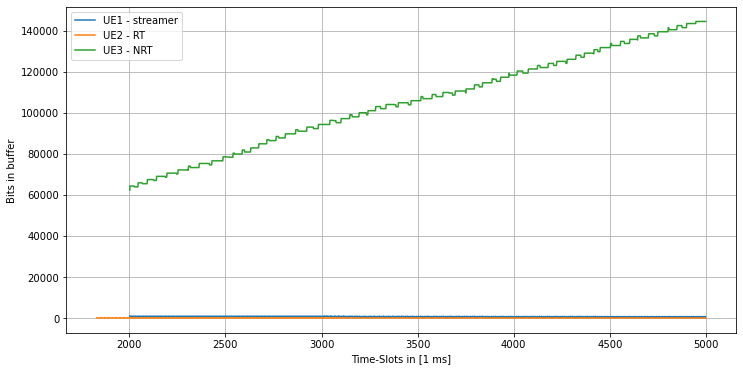

In [599]:
for i in np.arange(len(ue_comp)):
    if(ue_comp[i].qos==2):
        stream=i
    if(ue_comp[i].qos==1):    
        rt=i
    if(ue_comp[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
plt.plot(list(ue_comp[stream].mon.keys())[1000:3000],list(ue_comp[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_comp[rt].mon.keys())[1000:3000],list(ue_comp[rt].mon.values())[1000:3000],label='UE2 - RT')
plt.plot(list(ue_comp[nrt].mon.keys())[1000:3000],list(ue_comp[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

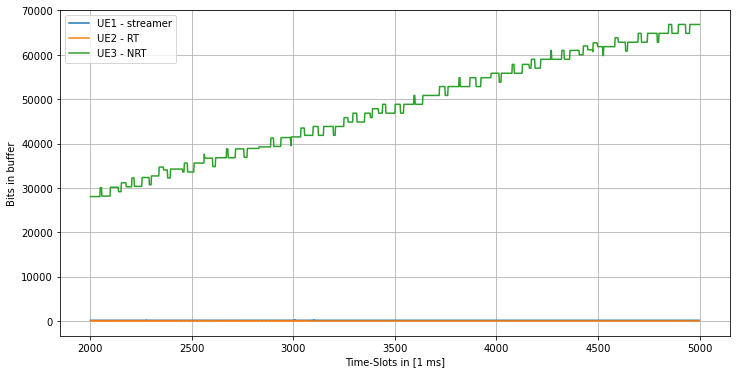

In [600]:
for i in np.arange(len(ue_list)):
    if(ue_list[i].qos==2):
        stream=i
    if(ue_list[i].qos==1):    
        rt=i
    if(ue_list[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
plt.plot(list(ue_list[stream].mon.keys())[1000:3000],list(ue_list[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_list[rt].mon.keys())[1000:3000],list(ue_list[rt].mon.values())[1000:3000],label='UE2 - RT')
plt.plot(list(ue_list[nrt].mon.keys())[1000:3000],list(ue_list[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

In [601]:
ue_list=ue_dict[19]
for i in ue_list:
    print('User')
    print(i.bits)
    print(i.mR)
    print(i.bits2)
    print(i.mR2)
    print(i.comp)

User
196000.0
78.43137254901953
196000
39.00944131153864
0
User
101892.0
40.77310924369739
194974.0
40.529419290725556
0
User
194000.0
77.63105242096844
196000.0
39.27416504817217
0
User
102522.0
41.025210084033645
194804.0
40.253425740043866
0
User
194000.0
77.63105242096832
194000.0
38.70599540336336
0
User
114750.0
45.91836734693881
198000.0
38.88968952927305
0
User
178707.5
71.51160464185686
198000.0
39.0441510737948
0
User
115700.0
46.29851940776313
190000.0
37.87099473642997
0
User
56060.0
22.43297318927573
105460.0
21.955674626793527
0
User
76518.0
30.619447779111603
146718.0
30.413512824097225
0
User
178618.75
71.47609043617456
200000.0
39.815610718076705
0
User
116100.0
46.45858343337336
198000.0
39.845165757379334
0
User
196000.0
78.43137254901951
196000.0
38.736262812447855
0
User
102732.0
41.10924369747905
192000.0
39.16012695594437
0
User
200000.0
80.0320128051219
200000
39.706318701950785
0
User
66258.0
26.513805522208884
125514.0
26.03204258894435
0
User
145178.75
58.094

In [658]:
ue_list=ue_dict[19]

In [670]:
prb_number_normal

31

In [667]:
C=0
nC=0
for i in ue_all:
    print('C:', i.mR)
    print('nC:',i.mR2)
    print('C-queue:', i.queue.level)
    print('nC-queue:',i.queue2.level)
    print('nC-queue:',i.qos)
    nC=nC+i.mR2
    C=C+i.mR

C: 35.07009868802282
nC: 39.03703926388798
C-queue: 125117.5
nC-queue: 0.0
nC-queue: 0.0
C: 57.225004647581024
nC: 16.798610309660283
C-queue: 57520.0
nC-queue: 108070.0
nC-queue: 0.0
C: 79.7671272358436
nC: 38.74122080708045
C-queue: 0.0
nC-queue: 6385.0
nC-queue: 0.0
C: 76.83756750893917
nC: 23.109955370132734
C-queue: 0.0
nC-queue: 82534.0
nC-queue: 0.0
C: 12.194443933655828
nC: 16.75319858329999
C-queue: 164070.0
nC-queue: 112280.0
nC-queue: 0.0
C: 77.65680249451054
nC: 22.8955755835957
C-queue: 0.0
nC-queue: 85626.0
nC-queue: 0.0
C: 34.927769532789185
nC: 38.40974303782263
C-queue: 102425.0
nC-queue: 0.0
nC-queue: 0.0
C: 25.089946308886677
nC: 34.36956256805466
C-queue: 139000.0
nC-queue: 32300.0
nC-queue: 0.0
C: 35.16086101724678
nC: 39.20830318045936
C-queue: 105325.0
nC-queue: 0.0
nC-queue: 0.0
C: 12.184426937497426
nC: 16.785750119900268
C-queue: 168090.0
nC-queue: 116110.0
nC-queue: 0.0
C: 57.52019106621164
nC: 16.802867870676444
C-queue: 49108.75
nC-queue: 114050.0
nC-queue:

In [676]:
mean_tbs=0
for i in ue_all:
    mean_tbs+=i.tbs
    
mean_tbs=mean_tbs/len(ue_all)

mean_tbs2=0
ue_list=ue_dict[19]
for i in ue_list:
    mean_tbs2+=i.tbs
ue_list=ue_dict[20]
for i in ue_list:
    mean_tbs2+=i.tbs
    
mean_tbs2=mean_tbs2/(len(ue_dict[19])+len(ue_dict[20]))

In [680]:
print('all:',mean_tbs)
print('no comp:',mean_tbs2)

all: 50.69464285714286
no comp: 59.725


In [689]:
ue_all_19=ue_all[0:69]
av=0
for i in ue_all_19:
    av+=i.mR/i.mR2
av=av/70

In [690]:
av

1.5932362043365778